# Literature

## Datasets

* 100 song dataset and benchmark of current algorithms: [The 2015 Signal Separation Evaluation Campaign](https://hal.inria.fr/hal-01188725/document)
* MIR-1K: https://sites.google.com/site/unvoicedsoundseparation/mir-1k

## Papers


* [Deep Karaoke: Extracting Vocals from Musical Mixtures Using a Convolutional Deep Neural Network](https://arxiv.org/abs/1504.04658)

* Silly web implementation of DNN mixer: [Remixing musical audio on the web using source separation](https://smartech.gatech.edu/bitstream/handle/1853/54602/WAC2016-93.pdf)

* [Deep Neural Networks for Single Channel Source Separation](https://arxiv.org/pdf/1311.2746.pdf)
 * Train DNN to classify spectral frame as "vocal" or "music". Then find two vectors (a normal optimization problem) that sum to the mixed signal and the DNN classifies them as cleanly as possible.

* [Singing-voice Separation from Monaural Recordings using Deep Recurrent Neural Networks](http://paris.cs.illinois.edu/pubs/huang-ismir2014.pdf)
 * Use recurrent DNN to produce separated signals
 * Still uses time-frequency masking: use the DNN-produced signals just to infer mask factor and use that mask against the original audio
 * Trained model available at https://github.com/posenhuang/deeplearningsourceseparation

* Enhance separation after initial separation
 * [Discriminative Enhancement for Single Channel Audio Source Separation using Deep Neural Networks](https://arxiv.org/pdf/1609.01678.pdf)
 * [Two Stage Single Channel Audio Source Separation using Deep Neural Networks](http://epubs.surrey.ac.uk/841432/1/Two%20Stage%20Single%20Channel%20Audio%20Source%20Separation%20using%20Deep%20Neural%20Networks.pdf)
 
* [Deep Clustering and Conventional Networks for Music Separation: Stronger Together](https://arxiv.org/pdf/1611.06265.pdf)
 * Multitask: deep clustering and mask inference
 * According to authors' [website](http://naplab.ee.columbia.edu/ivs.html), achieved the best performance in Singing Voice Separation task of the Music Information Retrieval Evaluation eXchange (MIREX 2016)
 * TODO: Read through carefully



## Performance measurement

[Proposals for Preformance Measurement in Source Separation](https://hal.archives-ouvertes.fr/inria-00570123/document)
[Python library mir_eval for computing metrics](https://github.com/craffel/mir_eval)





In [59]:
#import keras
from scipy.io import wavfile
import numpy as np
import IPython
import matplotlib.pyplot as plt

%matplotlib inline




### Try that audio works in jupyter

This is a markdown cell

In [15]:

framerate = 44100
t = np.linspace(0,5,framerate*5)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
IPython.display.Audio(data,rate=framerate)

### Splice mp3 files to 10-second wav chunks

In [30]:
!ls data

chunk_seconds = 10
piece = "Fintelligens - Stockholm-Helsinki"
for part in ["instrumental", "with-vocals"]:
    prefix = "data/{}/{}".format(piece, part)
    !mkdir -p "{prefix}"
    log = !ffmpeg -i "{prefix}.mp3" -f segment -segment_time {chunk_seconds} "{prefix}/%03d.wav"


Fintelligens - Stockholm-Helsinki


### Load a pair or chunks and visualize side by side


Loaded data/Fintelligens - Stockholm-Helsinki/instrumental/000.wav (441216, 2)
Loaded data/Fintelligens - Stockholm-Helsinki/with-vocals/000.wav (441216, 2)


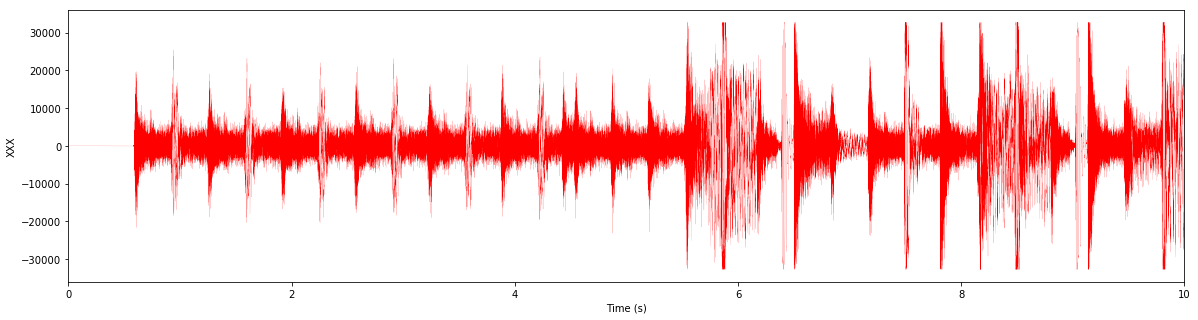

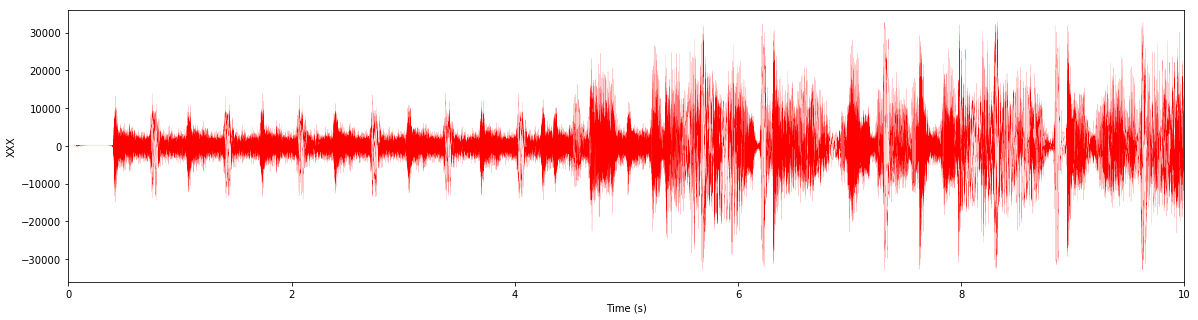

In [119]:

data = {}
for (i, part) in enumerate(["instrumental", "with-vocals"]):
    filename = "data/{}/{}/000.wav".format(piece, part)
    raw = wavfile.read(filename)
    data[i] = np.array(raw[1],dtype=float)
    print("Loaded", filename, data[i].shape)

arr = data[0]

framerate = data[0].shape[0] / chunk_seconds

def get_x(y):
    return np.arange(0, y.shape[0], dtype=float) / framerate

def init_fig():
    plt.figure(figsize=(20,5))
    plt.ylabel("XXX")
    plt.xlabel("Time (s)")
    axes = plt.gca()
    axes.set_xlim([0, chunk_seconds])
    plt.ticklabel_format(style='plain', axis='x', scilimits=(0,1000))

def audio(data, framerate):
    IPython.display.display(IPython.display.Audio(data,rate=framerate))


for part in [0, 1]:
    for channel in [0]:
        init_fig()
        y = data[part][:,channel]
        plt.plot(get_x(y), y, linewidth=0.1, color='red')
        audio(data[part][:,0], framerate)
        
# TODO: utilize both stereo channels somehow?



### Match time

The instrumental and with-vocal tracks may be off sync. Find the starting point (assuming that the track starts from silence and only works for the first clip of the track - this may need to be revisited), and shift both tracks to start from that point.

Audio starts at sample 25903 (t = 0.5870820641137221 s)
Audio starts at sample 17404 (t = 0.3944553234696838 s)
Correction shift:  8499
(415313, 2)


(423812, 2)


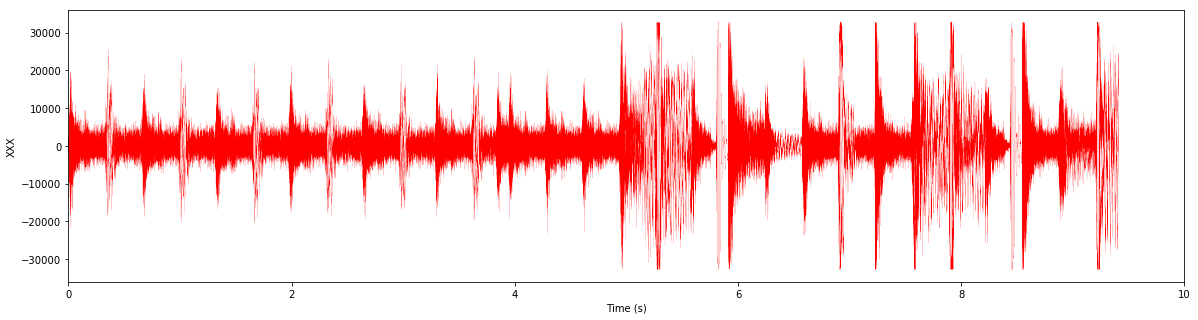

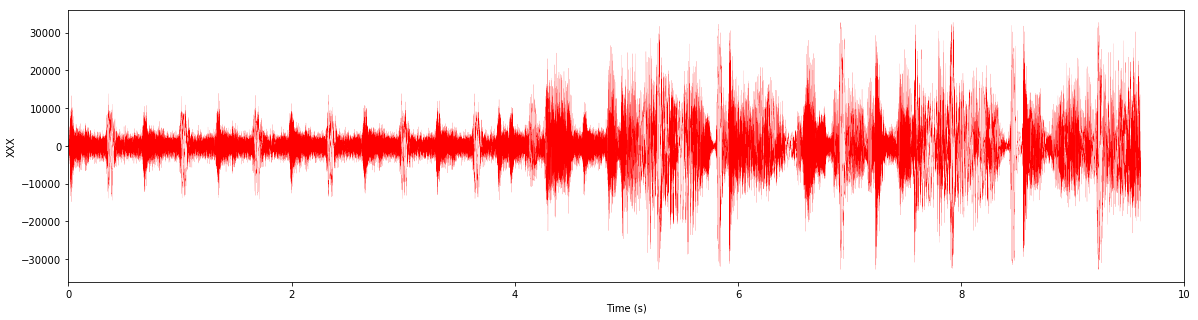

In [128]:
def index_of_first(iterable, predicate):
    return next(i for i, x in enumerate(iterable) if predicate(x))

start = {}
for part in [0,1]:
    mag = data[part][:,0]
    start[part] = index_of_first(mag, lambda x: x > 100)
    print('Audio starts at sample {} (t = {} s)'.format(start[part], start[part] / framerate))
    
shift = start[0] - start[1]
print('Correction shift: ', shift)

def shift_data(part):
    d = np.roll(data[part], -start[part], 0)
    d.resize([d.shape[0] - start[part], 2])
    print(d.shape)
    init_fig()
    y = d[:,0]
    plt.plot(get_x(y), y, linewidth=0.1, color='red')
    audio(d[:,0], framerate)
    return d

shifted_data = {}
for part in [0,1]:
    shifted_data[part] = shift_data(part)
    
    

### Match volume

Scaling:  223754619.0 161671982.0 1.38400368593
Clamping:  32767.0 32767.0


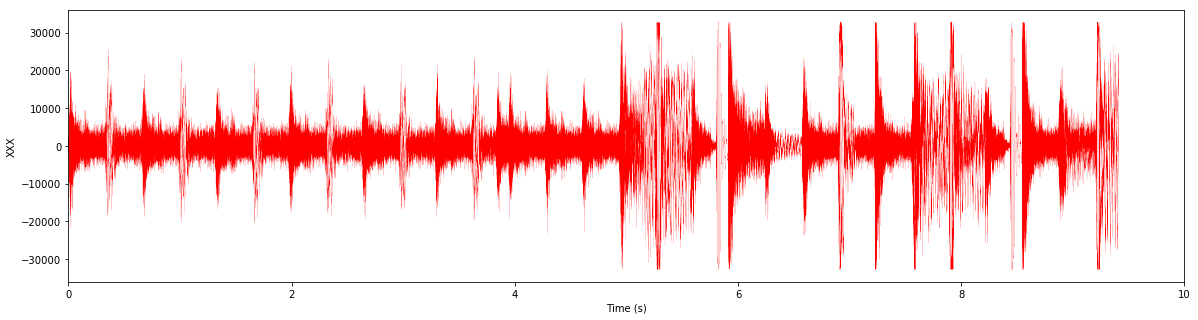

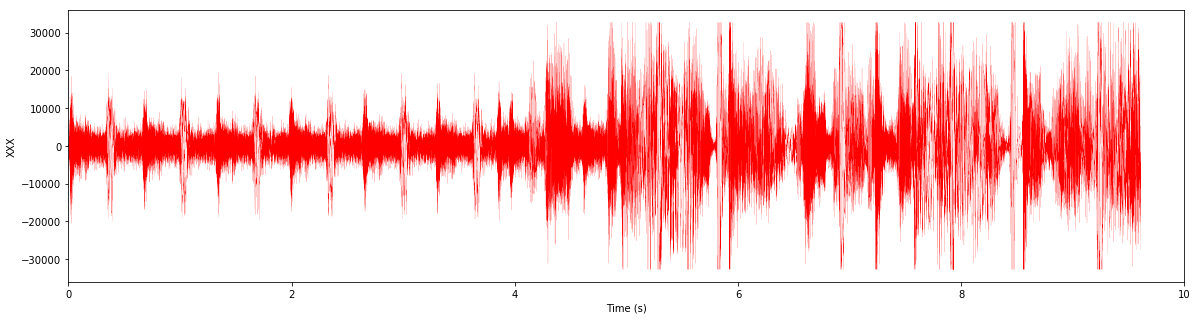

In [140]:
from numpy.linalg import norm

window = int(2 * framerate)
n0 = norm(shifted_data[0][0:window,0], 1)
n1 = norm(shifted_data[1][0:window,0], 1)

max0 = max(shifted_data[0][:,0])
min0 = min(shifted_data[0][:,0])

print("Scaling: ", n0, n1, n0 / n1)
print("Clamping: ", m0, m1)

# Scale
normalized_data = {}
normalized_data[0] = shifted_data[0]
normalized_data[1] = np.clip(shifted_data[1] * (n0 / n1), min0, max0)

# And clamp
for part in [0, 1]:
    init_fig()
    d = normalized_data[part]
    y = d[:,0]
    plt.plot(get_x(y), y, linewidth=0.1, color='red')
    audio(d[:,0], framerate)


### Preprocess the chunks

We need to align the timing of the chunks to match, and scale (not sure if scaling is needed, doesn't affect DFT?).
Should we take DFT and only align time after that?
What would be a good metric for alignment? Start by trying L2 norm?
If we align in time space with L2 norm, we need to normalize first. Maybe try going to frequency space first?

TODO:
* Try STDFT
 * "The spectral representation is extracted using a 1024-point short time Fourier transform (STFT) with 50% overlap." (Huang et al)
* Try recovering just the vocal signal
* Can create more training data by time-shifting isolated vocal signal and mixing on top of instrumental
* Can we use some of the quality measures directly as a cost function...?


In [ ]:
from scipy.fftpack import fft